# Pulsar Star: Light GBM W Random Search 

## Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Exploring the Data 

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')
train_df.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [3]:
train_df.isna().sum()
train_df = train_df.drop('id', axis = 1)


## Checking for Class Imbalance
We can see that this dataset is very class imbalanced. When evaluating our model, we cannot use accuracy as it does not work well with class imbalanced models. Most of the times, when doing competitions on Kaggle, the loss function that Kaggle uses to evaluate our model is listed. When checking this, we can see that they use log loss

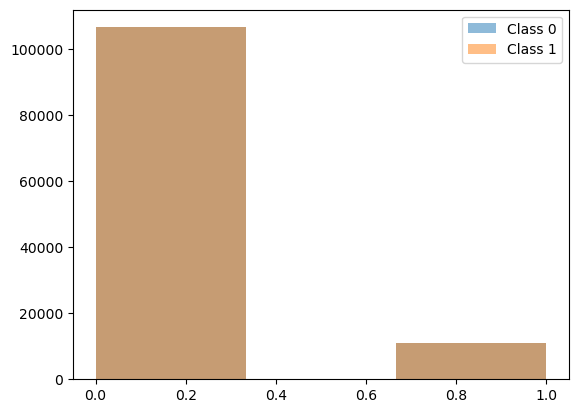

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram for each class
for label in np.unique(train_df['Class']):
    plt.hist(train_df['Class'], bins=3, alpha=0.5, label='Class {}'.format(label))

# Add a legend and show the plot
plt.legend()
plt.show()

## Preprocessing 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X = train_df.drop('Class', axis = 1)
y = train_df['Class']
X

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765
...,...,...,...,...,...,...,...,...
117559,132.843750,56.748838,-0.060070,-0.554084,4.054348,27.844144,6.564423,44.442664
117560,112.578125,52.539271,0.179580,-0.306961,1.637960,15.331913,11.384718,142.535470
117561,119.757812,49.980013,0.064402,-0.270822,3.877926,19.788559,6.959740,56.367789
117562,105.789062,46.986595,0.441426,0.372466,2.097826,17.170612,9.442445,99.074539


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True) 

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_train

array([[ 0.47867201,  1.45924867, -0.42755451, ...,  3.17852746,
        -2.30708755, -1.18898792],
       [ 0.87762334, -0.81795721, -0.27468121, ..., -0.37215596,
        -0.04734734, -0.29896361],
       [ 0.38443153,  0.2742307 , -0.07237834, ..., -0.77005154,
         3.24724672,  4.41302233],
       ...,
       [ 0.30212819,  0.03787757, -0.32461064, ..., -0.45594243,
         0.24824627, -0.02561422],
       [-3.51555339, -1.14944539,  3.25174528, ...,  2.52730563,
        -1.92086987, -1.18757808],
       [ 0.83018897, -0.21082058, -0.4004316 , ..., -0.37060205,
        -0.0660523 , -0.29980852]])

## Baseline Model

In [9]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from scipy.stats import randint


In [10]:
model = LGBMClassifier()
model.fit(X_train, y_train)


LGBMClassifier()

In [11]:
y_pred = model.predict(X_val)
logloss = log_loss(y_val, y_pred)
logloss

0.3617701781921343

## Using Random Search for Hyper Parameter tuning
Even though the baseline model did really well, lets see how effective hyper parameter tuning would be for reducing the loss even more

In [12]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

In [13]:
lgbm = LGBMClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_log_loss',
                                   n_jobs=-1, cv=5)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7838b0ee8a30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7838b0ee8e50>},
                   scoring='neg_log_loss')

In [14]:
print(random_search.best_params_)


{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 225}


In [15]:
best_model = LGBMClassifier(learning_rate= 0.01, max_depth= 7, n_estimators= 581)
best_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=7, n_estimators=581)

In [16]:

new_y_pred = best_model.predict(X_val)
new_logloss = log_loss(y_val, new_y_pred)
new_logloss

0.3387763109341596

## Submission

In [17]:
test_scaler = StandardScaler()
scaled_test = test_df.drop('id', axis =1)
scaled_test = test_scaler.fit_transform(scaled_test)


In [18]:

prediction=best_model.predict(scaled_test)
submission=pd.DataFrame({'id':test_df.id,'Class':prediction})
submission.to_csv('submission.csv',index=False)

In [19]:
submission

,id,Class
0,117564,0
1,117565,0
2,117566,0
3,117567,0
4,117568,0
...,...,...
78372,195936,0
78373,195937,0
78374,195938,0
78375,195939,0
